In [1]:
%pylab inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


## (a) Download the data and plot a histogram.

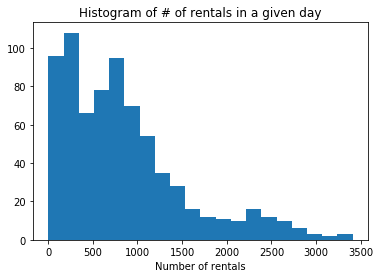

In [2]:
# Load bikeshare.csv, you might want to look into the read_csv function in pandas.
# The columns of the data are:
# sunny: 1 if the day was sunny, 0 otherwise.
# working_day: 1 if the day was a working day, 0 otherwise.
# month: the month the day was in, where the first month is 1.
# num_rentals: the number of people that rented a bike on the day.
data = pd.read_csv('bikeshare.csv') # TODO

# Plot a histogram of the number of rentals in a given day with 20 bins.
# TODO
plt.figure()
plt.hist(data['num_rentals'], bins=20)
plt.xlabel('Number of rentals')
plt.title('Histogram of # of rentals in a given day')
plt.show()

## (b) Use Gibb's sampling to simulate from the graphical model in the problem statement.

### (i) Implement `get_subgroup_statistics`.

In [3]:
def get_subgroup_statistics(data):
    """
    Given bikesharing data, returns the means, standard deviations, and counts
    split by categories sunny and working_day.
    
    Parameters
    ----------
    data : dataframe
        A dataframe of bikesharing data with 0/1 categories `sunny` and `working_day`
        and numerical value `num_rentals`.
        
    Returns
    -------
    means : 2x2 array of floats
        An array where mean[i, j] corresponds to the empirical mean of rentals for
        all days with working_day=i and sunny=j.
    stds : 2x2 array of floats
        An array where stds[i, j] corresponds to the empirical standard deviation
        of rentals for all days with working_day=i and sunny=j.
    counts : 2x2 array of floats
        An array where mean[i, j] corresponds to the total number of rentals for
        all days with working_day=i and sunny=j.
    """
    num_categories = 2
    means = np.zeros((num_categories, num_categories))
    stds = np.zeros((num_categories, num_categories))
    counts = np.zeros((num_categories, num_categories))
    
    # Iterate through all possible combinations of working_day and sunny.
    for working_day in range(2):
        for sunny in range(2):
            filter1 = data['working_day'] == working_day
            filter2 = data['sunny'] == sunny
            counts[working_day, sunny] = data.where(filter1 & filter2)['num_rentals'].sum() # TODO
            means[working_day, sunny] = data.where(filter1 & filter2)['num_rentals'].mean() # TODO
            stds[working_day, sunny] = data.where(filter1 & filter2)['num_rentals'].std()# TODO

    return means, stds, counts

Now that we've implemented `get_subgroup_statistics`, let's see what one of its output looks like.

In [4]:
means, stds, counts = get_subgroup_statistics(data)
print("counts:")
print("         rainy   sunny")
print("weekend  {0}    {1}".format(counts[0, 0], counts[0, 1]))
print("workday  {0}   {1}".format(counts[1, 0], counts[1, 1]))

counts:
         rainy   sunny
weekend  85263.0    231469.0
workday  88408.0   214877.0


### (ii) Fill in the following code:

In [5]:
def sample_num_rentals(workday, sunny, means, stds):
    """
    Randomly sample the number of bike rentals from one of four Gaussians depending
    on the given daily conditions.
    
    Parameters
    ----------
    workday : int
        1 if the day we wish to sample for is a workday, 0 if it's a weekend.
    sunny : int
        1 if the day we wish to sample for is sunny, 0 if it's rainy.
    means : 2x2 array of floats
        An array where mean[i, j] corresponds to the mean of the Gaussian
        we sample from when working_day=i and sunny=j.
    stds : 2x2 array of floats
        An array where mean[i, j] corresponds to the standard deviation of the Gaussian
        we sample from when working_day=i and sunny=j.
        
    Returns
    -------
    count : float
        A Gaussian sampled count.
    """
    mu, sigma = means[workday, sunny], stds[workday, sunny]
    return np.random.normal(loc=mu, scale=sigma, size=1) # TODO


def simulate_rentals(num_samples, p_workday, p_sunny, means, stds):
    """
    Simulate `num_samples` days by using the sampling procedure defined
    in the homework sheet.
    
    Parameters
    ----------
    num_samples : int
        The number of days to simulate.
    p_workday : float
        The probability that any given day will be a workday.
    p_sunny : float
        The probability that any given day will be sunny.
    means : 2x2 array of floats
        An array where mean[i, j] corresponds to the mean of the Gaussian
        we sample from for the number of rentals when working_day=i and sunny=j.
    stds : 2x2 array of floats
        An array where stds[i, j] corresponds to the standard deviation of the Gaussian
        we sample from for the number of rentals when working_day=i and sunny=j.
        
    Returns
    -------
    samples : num_samples x 3 array of floats
        The generated samples where samples[i, 0] is 1 if day i was a workday,
        samples[i, 1] is 1 if day i was sunny, and samples[i, 2] is the number
        of rentals that happened on that day.
    """
    samples = np.zeros((num_samples, 3))
    for t in range(num_samples):
        x_t = np.zeros(3)
        x_t[0] = np.random.binomial(n=1, p=p_workday) # TODO: This should be a bernouili sample that repesents workday.
        x_t[1] = np.random.binomial(n=1, p=p_sunny) # TODO: This should be a bernouilli sample that represents sunny.
        x_t[2] = sample_num_rentals(workday=int(x_t[0]), sunny=int(x_t[1]), means=means, stds=stds) # TODO: The sampled number of rentals. You might want to cast x_t[0], x_t[1] to ints.
        samples[t] = x_t
        
    return samples

## (c) Draw 1000 samples; plot a histogram of the resulting draws for the number of bikes in a given day.

Text(0.5, 1.0, 'average day simulations')

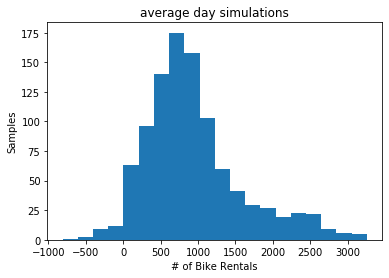

In [6]:
# Assume a 5 day workweek; ignore holidays.
p_workday = 5.0 / 7.0

# Use the fraction of sunny days from your dataset.
frac_sunny_days = data.where(data['sunny'] == 1).shape[0] / data.shape[0] # TODO
p_sunny = frac_sunny_days

# Get the data statistics.
means, stds, counts = get_subgroup_statistics(data)

T = 1000
samples = simulate_rentals(num_samples=T,
                           p_workday=p_workday,
                           p_sunny=p_sunny,
                           means=means,
                           stds=stds)

# Plot the histogram.
plt.hist(samples[:, 2], bins=20)
plt.xlabel("# of Bike Rentals");
plt.ylabel("Samples");
plt.title("average day simulations")

## (d) Run 1000 simulations given a forecast of 80% rain tomorrow; plot a histogram of the resulting draws for the number of bikes in a given day.


### (i) if tomorrow is a weekday

Text(0.5, 1.0, '80% rainy working day')

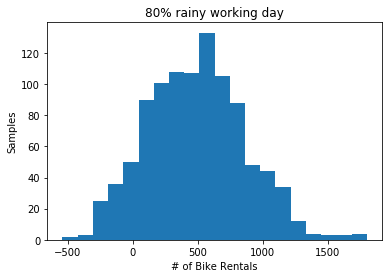

In [7]:
p_workday = 1 # TODO
p_sunny = 0.2 # TODO

T = 1000 # TODO
samples = simulate_rentals(num_samples=T,
                           p_workday=p_workday,
                           p_sunny=p_sunny,
                           means=means,
                           stds=stds)

plt.hist(samples[:, 2], bins=20)
plt.xlabel("# of Bike Rentals");
plt.ylabel("Samples");
plt.title("80% rainy working day")

### (ii) if tomorrow is a weekend

Text(0.5, 1.0, '80% rainy weekend day')

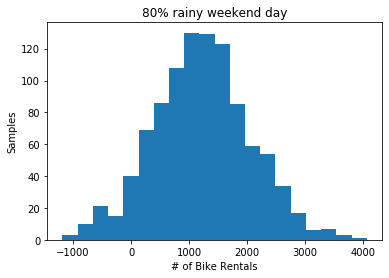

In [8]:
p_workday = 0 # TODO
p_sunny = 0.2 # TODO

T = 1000 # TODO
samples = simulate_rentals(num_samples=T,
                           p_workday=p_workday,
                           p_sunny=p_sunny,
                           means=means,
                           stds=stds)

plt.hist(samples[:, 2], bins=20)
plt.xlabel("# of Bike Rentals");
plt.ylabel("Samples");
plt.title("80% rainy weekend day")

## (e) Can you run the procedure to its completion using only the first ten entries of data?

In [9]:
data_smaller = data.head(10) # TODO

means, stds, counts = get_subgroup_statistics(data_smaller)
print("counts:")
print("         rainy sunny")
print("weekend  {0}   {1}".format(counts[0,0], counts[0,1]))
print("workday  {0}   {1}".format(counts[1,0], counts[1,1]))
frac_sunny_days = data['sunny'].mean()
print('fraction sunny days: {0:.2f}'.format(frac_sunny_days))


counts:
         rainy sunny
weekend  0.0   6042.0
workday  484.0   2278.0
fraction sunny days: 0.63


**TODO: Fill this in, can you run the procedure to completion?**

Yes, it can be run to completion. Although, I believe that the samples produced will not be as accurate.

## (f) Implement the missing code below.

In [10]:
def sample_mu_by_category(prior_means, prior_sigma, working_day, sunny):
    """
    Sample mu from a Gaussian prior that depends on the properties of the day.
    
    Parameters
    ----------
    prior_means : 2x2 array of floats
        The prior means where prior_means[i, j] is the prior mean for days
        with working_day=i and sunny=j.
    prior_sigma : float
        The standard deviation of the prior from which we are sampling.
    working_day : int
        1 if we are sampling the mean for a day that is a workday and 0 for
        a day that is a weekend.
    sunny : int
        1 if we are sampling the mean for a day that is sunny and 0 for
        a day that is rainy.
        
    Returns
    -------
    mu : float
        The sampled mean.
    """
    prior_mean = prior_means[working_day, sunny] # TODO
    return np.random.normal(prior_mean, prior_sigma)


def prior_prob_by_category(observed_mu, prior_means, prior_sigma, working_day, sunny):
    """
    Compute the probability that we observed mu given specific properties of the day.
    
    Parameters
    ----------
    observed_mu : float
        The value of mu for which we wish to compute the prior probability.
    prior_means : 2x2 array of floats
        The prior means where prior_means[i, j] is the prior mean for days
        with working_day=i and sunny=j.
    prior_sigma : float
        The standard deviation of the prior from which we are sampling.
    working_day : int
        1 if we are sampling the mean for a day that is a workday and 0 for
        a day that is a weekend.
    sunny : int
        1 if we are sampling the mean for a day that is sunny and 0 for
        a day that is rainy.
        
    Returns
    -------
    prob : float
        The computed probability.
    """
    prior_mean = prior_means[working_day, sunny] # TODO
    return prior_mean # TODO


def compute_likelihood(data, likelihood_means, likelihood_sigma):
    """
    Compute the likelihood that we observed the data given the
    means across the four daily categories.
    
    Parameters
    ----------
    data : dataframe
        A dataframe of bikesharing data with 0/1 categories `sunny` and `working_day`
        and numerical value `num_rentals`.
    likelihood_means : 2x2 array of floats
        The likelihood means where sampled_means[i, j] is the likelihood mean when
        work_day=i and sunny=j.
    likelihood_sigma : float
        The standard deviations of the Gaussians from which the data is drawn.

    Returns
    -------
    prob : float
        The likelihood of the data, may be scaled by a fixed constant.
    """
    sunny = data["sunny"].values
    working_day = data["working_day"].values
    num_rentals = data["num_rentals"].values
    
    likelihood = 1
    # Assume draws are i.i.d. so that likelihoods of each datapoint multiply.
    for i in range(len(data)):
        x = num_rentals[i]
        # mu_this_category is the sampled mean for the sunny/workday combo of row i.
        mu_this_category = likelihood_means[working_day[i], sunny[i]]

        # Premultiply by 1e4 to keep numerical stability, 
        # because data is the same length every time this will be ok.
#         n = scipy.stats.norm(loc=mu_this_category, scale=likelihood_sigma[working_day[i], sunny[i]])
#         likelihood *= 1e4 * x * np.random.normal(mu_this_category, likelihood_sigma) # TODO
        likelihood *= 1e4 * scipy.stats.norm.pdf(x=x, loc=mu_this_category, scale=likelihood_sigma)
    return likelihood
    

def gibbs_sampling_posterior(data, num_samples, prior_means, prior_sigma, likelihood_sigma):
    """
    Sample likelihood parameters (the means) along with their posterior probability.
    
    Parameters
    ----------
    num_samples : int
        The number of samples to draw.
    prior_means : 2x2 array of floats
        The prior means associated to the likelihood means, where prior_means[i, j]
        is the prior mean for working_day=i and sunny=j.
    prior_sigma : float
        The standard deviation of all the prior Gaussians.
    likelihood_sigma : float
        The standard deviation of all the likelihood Gaussians.
    
    Returns
    -------
    samples : num_samples x 5 array of floats
        The array of all generated samples where samples[i] is the subarray with
        [mu_sunny_workday, mu_rainy_workday, mu_sunny_weekend, mu_rainy_weekend, c*p(theta, x)]
        where the last element is the posterior scaled by any arbitrary positive constant.
    """
    samples = np.zeros((num_samples, 5))
    for t in range(num_samples):
        # Sample the likelihood parameters.
        mu_sunny_workday = sample_mu_by_category(prior_means, prior_sigma, working_day=1, sunny=1) # TODO
        mu_sunny_weekend = sample_mu_by_category(prior_means, prior_sigma, working_day=1, sunny=0) # TODO
        mu_rainy_workday = sample_mu_by_category(prior_means, prior_sigma, working_day=0, sunny=1) # TODO
        mu_rainy_weekend = sample_mu_by_category(prior_means, prior_sigma, working_day=0, sunny=0) # TODO
        
        # Now compute the likelihood.
        theta = np.array([[mu_rainy_weekend, mu_sunny_weekend],
                          [mu_rainy_workday, mu_sunny_workday]])
        likelihood = compute_likelihood(data, theta, likelihood_sigma)
        
        # Compute P(theta).
        prior_sunny_work = prior_prob_by_category(mu_sunny_workday, prior_means, prior_sigma, working_day=1, sunny=1)
        prior_sunny_weekend = prior_prob_by_category(mu_sunny_weekend, prior_means, prior_sigma, working_day=0, sunny=1)
        prior_rainy_work = prior_prob_by_category(mu_rainy_workday, prior_means, prior_sigma, working_day=1, sunny=0)
        prior_rainy_weekend = prior_prob_by_category(mu_rainy_weekend, prior_means, prior_sigma, working_day=0, sunny=0)
        
        p_theta = prior_sunny_work * prior_sunny_weekend * prior_rainy_work * prior_rainy_weekend # TODO
    
        # Save the sample.
        x_t = np.zeros(5)
        x_t[0] = mu_sunny_workday
        x_t[1] = mu_rainy_workday
        x_t[2] = mu_sunny_weekend
        x_t[3] = mu_rainy_weekend
        x_t[4] = likelihood * p_theta # TODO: This should be the posterior probability that this sample was drawn.
        samples[t] = x_t

    return np.array(samples)

## (g) Plot the estimated distributions of the posterior marginals $p(\mu_{00}), p(\mu_{01}), p(\mu_{10})$, and $ p(\mu_{11})$ from your sample. To do so, plot a histogram of each draw for all means in your sample, weighted by the calculated posterior density associated with that draw. 

### Do this using the first 10 datapoints, and then 100 datapoints from the total data.

Text(0.5, 1.0, '10 data points')

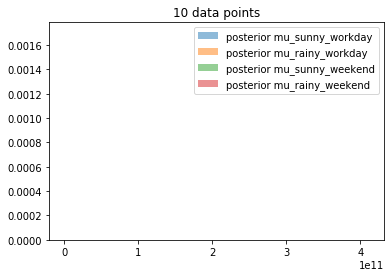

In [13]:
mu_rainy_weekend_prior = 4000
mu_rainy_workday_prior = 2000

mu_sunny_weekend_prior = 4000
mu_sunny_workday_prior = 2000

prior_sigma = 1000
likelihood_sigma = 1000

prior_means = np.array([[mu_rainy_weekend_prior, mu_sunny_weekend_prior],
                        [mu_rainy_workday_prior, mu_sunny_workday_prior]])

samples = gibbs_sampling_posterior(data[:10],
                                   num_samples=1000,
                                   prior_means=prior_means,
                                   prior_sigma=prior_sigma,
                                   likelihood_sigma=likelihood_sigma)
fig, ax = plt.subplots()

ax.hist(samples[:10][0], weights=samples[:10][4], label="posterior mu_sunny_workday", density=True, alpha=0.5)
ax.hist(samples[:10][1], weights=samples[:10][4], label="posterior mu_rainy_workday", density=True, alpha=0.5)
ax.hist(samples[:10][2], weights=samples[:10][4], label="posterior mu_sunny_weekend", density=True, alpha=0.5)
ax.hist(samples[:10][3], weights=samples[:10][4], label="posterior mu_rainy_weekend", density=True, alpha=0.5)

ax.legend(bbox_to_anchor=(1, 1))

plt.title("10 data points")

Text(0.5, 1.0, '100 data points')

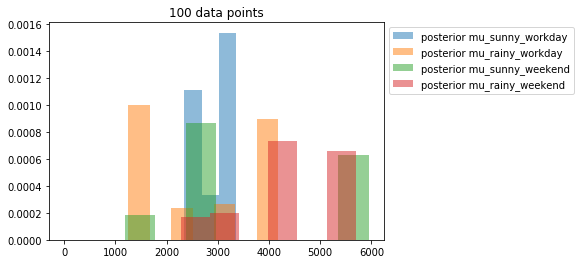

In [14]:
samples = gibbs_sampling_posterior(data[:100],
                                   num_samples=1000,
                                   prior_means=prior_means,
                                   prior_sigma=prior_sigma,
                                   likelihood_sigma=likelihood_sigma)

fig, ax = plt.subplots()

ax.hist(samples[:10][0], weights=samples[:10][4], label="posterior mu_sunny_workday", density=True, alpha=0.5)
ax.hist(samples[:10][1], weights=samples[:10][4], label="posterior mu_rainy_workday", density=True, alpha=0.5)
ax.hist(samples[:10][2], weights=samples[:10][4], label="posterior mu_sunny_weekend", density=True, alpha=0.5)
ax.hist(samples[:10][3], weights=samples[:10][4], label="posterior mu_rainy_weekend", density=True, alpha=0.5)

ax.legend(bbox_to_anchor=(1, 1))

plt.title("100 data points")

## (h) Compare and contrast the two motivations above. specifically, address (i) what quantity are you sampling (and thus plotting in the histogram) in each method, and (ii) which approach you would prefer for a small dataset, and why. 

TODO: Fill this in